# Evaluations

## Installations and Imports

In [96]:
!pip install torch_geometric

In [97]:
import random
import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.utils.convert import from_scipy_sparse_matrix
import scipy.sparse as sp
from torch_geometric.data import Data

from torch_geometric.datasets import CitationFull
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

import numpy as np

from torch_geometric import seed_everything
seed_everything(0)

## Loading the Datasets
Here we load in two different distributions of the CoraML dataset.

### From G2G Repo Dataset

We load this dataset according to the [g2g repo](https://github.com/abojchevski/graph2gauss/blob/master/g2g/utils.py#L461). The advantage of this distribution is that it contains mappings from the nodes back to the abstract's text of the original papers, which could allow us to perform qualitative evaluations down the line.

In [98]:
with np.load('./data/cora_ml.npz', allow_pickle = True) as loader:
    loader = dict(loader)
    g2g_adj = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
                       loader['adj_indptr']), shape=loader['adj_shape'])

    g2g_x = sp.csr_matrix((loader['attr_data'], loader['attr_indices'],
                       loader['attr_indptr']), shape=loader['attr_shape'])

    print("ABSTRACTS:\n", loader['attr_text'])
    abstracts = loader['attr_text']

pt_g2g_x = torch.tensor(g2g_x.toarray(), dtype=torch.float)
pt_g2g_edge_index = from_scipy_sparse_matrix(g2g_adj)[0]
g2g_cora_ml = Data(x=pt_g2g_x, edge_index=pt_g2g_edge_index)
print("\nGRAPH DATA:")
g2g_cora_ml

ABSTRACTS:
 ["Intelligent information retrieval (IIR) requires inference. The number of inferences that can be drawn by even a simple reasoner is very large, and the inferential resources available to any practical computer system are limited. This problem is one long faced by AI researchers. In this paper, we present a method used by two recent machine learning programs for control of inference that is relevant to the design of IIR systems. The key feature of the approach is the use of explicit representations of desired knowledge, which we call knowledge goals. Our theory addresses the representation of knowledge goals, methods for generating and transforming these goals, and heuristics for selecting among potential inferences in order to feasibly satisfy such goals. In this view, IIR becomes a kind of planning: decisions about what to infer, how to infer and when to infer are based on representations of desired knowledge, as well as internal representations of the system's inferenti

Data(x=[2995, 2879], edge_index=[2, 8416])

In [99]:
g2g_cora_ml.edge_index

tensor([[   0,    0,    0,  ..., 2993, 2993, 2993],
        [1638, 2357, 1636,  ..., 1865,  745,  200]])

In [100]:
abstracts[200]

'One of the persistent themes in Artificial Life research is the use of co-evolutionary arms races in the development of specific and complex behaviors. However, other than Simss work on artificial robots, most of the work has attacked very simple games of prisoners dilemma or predator and prey. Following Tesauros work on TD-Gammon, we used a 4000 parameter feed-forward neural network to develop a competitive backgammon evaluation function. Play proceeds by a roll of the dice, application of the network to all legal moves, and choosing the move with the highest evaluation. However, no back-propagation, reinforcement or temporal difference learning methods were employed. Instead we apply simple hill-climbing in a relative fitness environment. We start with an initial champion of all zero weights and proceed simply by playing the current champion network against a slightly mutated challenger, changing weights when the challenger wins. Our results show co-evolution to be a powerful machin

## Initial Model Testing

Basic model adapted from PyG's [link prediction](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py) example code.

### Model Definition and Setup

In [101]:
class Net(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def encode(self, x, edge_index):
    a1 = self.conv1(x, edge_index).relu()
    a2 = self.conv2(a1, edge_index)
    return a2

  def decode(self, z, edge_label_index):
    return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

  def decode_all(self, z):
    s = z @ z.T
    return (s > 0).nonzero(as_tuple=False).T


In [102]:
def train(model, train_data, val_data, optimizer, criterion, n_epochs=100):

  train_error = np.zeros(n_epochs)
  val_error = np.zeros(n_epochs)

  for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      train_auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().numpy())
      train_error[epoch-1] = 1 - train_auc

    val_auc = evaluate(model, val_data)

    val_error[epoch-1] = 1 - val_auc

    if epoch % 10 == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

  return model, train_error, val_error


In [103]:
@torch.no_grad()
def evaluate(model, data):
  model.eval()
  z = model.encode(data.x, data.edge_index)
  out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

  return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


### Test on G2G Dataset

In [104]:
graph = g2g_cora_ml

split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

In [105]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2995, 2879], edge_index=[2, 7316], edge_label=[3658], edge_label_index=[2, 3658])
Data(x=[2995, 2879], edge_index=[2, 7316], edge_label=[430], edge_label_index=[2, 430])
Data(x=[2995, 2879], edge_index=[2, 7746], edge_label=[860], edge_label_index=[2, 860])


In [106]:
EPOCHS = 100

model = Net(g2g_cora_ml.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
model, train_errs, val_errs  = train(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_auc = evaluate(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.655, Val AUC: 0.790
Epoch: 020, Train Loss: 0.605, Val AUC: 0.823
Epoch: 030, Train Loss: 0.537, Val AUC: 0.882
Epoch: 040, Train Loss: 0.475, Val AUC: 0.889
Epoch: 050, Train Loss: 0.465, Val AUC: 0.910
Epoch: 060, Train Loss: 0.448, Val AUC: 0.919
Epoch: 070, Train Loss: 0.430, Val AUC: 0.919
Epoch: 080, Train Loss: 0.433, Val AUC: 0.921
Epoch: 090, Train Loss: 0.425, Val AUC: 0.922
Epoch: 100, Train Loss: 0.416, Val AUC: 0.921
Test: 0.929


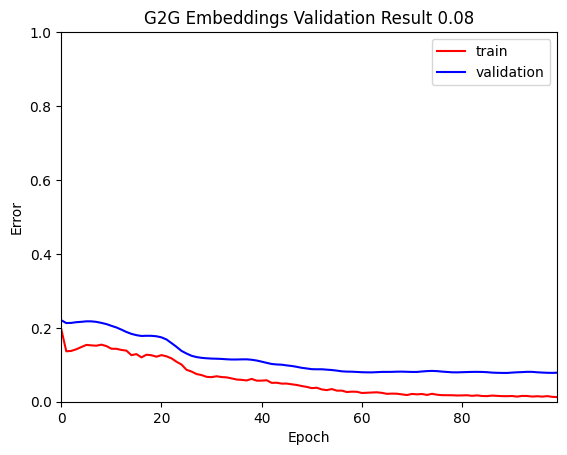

In [107]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_ylim(0,1); ax.set_xlim(0,EPOCHS-1)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('G2G Embeddings Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()

### Qualitative Evaluations

Let's use the paper at index 3, a paper describing a compression algorithm for probability transition matrices.

In [108]:
abstracts[3]

'This paper describes a compression algorithm for probability transition matrices. The compressed matrix is itself a probability transition matrix. In general the compression is not error-free, but the error appears to be small even for high levels of compression.'

Create test edges. We want a potential edge pointing from 3 to every other node, and have our model score how likely each of these are.

In [109]:
qtarg = np.full(2994, 3)
qother = np.hstack((np.arange(3), np.arange(4, 2995)))
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[   3,    3,    3,  ...,    3,    3,    3],
        [   0,    1,    2,  ..., 2992, 2993, 2994]])

Have our model do the prediction and sort the potential papers in descending order of score.

In [110]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [111]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted

array([2374,  266, 1994, ..., 1474, 1233, 1149])

In [112]:
qsorted[:10]

array([2374,  266, 1994,  473,  384, 1487,  471,  448,  269,  510])

These are the 3 papers that our test paper (3) actually cites. As we can see, two of them deal with genetic algorithms.

In [113]:
graph.edge_index[:, graph.edge_index[0] == 3].numpy()

array([[  3,   3,   3],
       [253, 507, 254]])

In [114]:
for i in graph.edge_index[:, graph.edge_index[0] == 3][1].numpy():
  print(abstracts[i])

Our theoretical understanding of the properties of genetic algorithms (GAs) being used for function optimization (GAFOs) is not as strong as we would like. Traditional schema analysis provides some first order insights, but doesn't capture the non-linear dynamics of the GA search process very well. Markov chain theory has been used primarily for steady state analysis of GAs. In this paper we explore the use of transient Markov chain analysis to model and understand the behavior of finite population GAFOs observed while in transition to steady states. This approach appears to provide new insights into the circumstances under which GAFOs will (will not) perform well. Some preliminary results are presented and an initial evaluation of the merits of this approach is provided.
Evolutionary computation uses computational models of evolution - ary processes as key elements in the design and implementation of computer-based problem solving systems. In this paper we provide an overview of evolu

Here are our top 3 predictions. We see a genetic algorithms paper in there but it has nothing to do with compression algorithms or stochastic modeling. The other two papers are also quite irrelevant.

In [115]:
for i in qsorted[:3]:
  print(abstracts[i])

This paper discusses the problem of how to implement many-to-many, or multi-associative, mapping within connectionist models. Traditional symbolic approaches work through explicit representation of all alternatives via stored links, or implicitly through enumerative algorithms. Classical pattern association models ignore the issue of generating multiple outputs for a single input pattern, and while recent research on recurrent networks is promising, the field has not clearly focused upon multi-associativity as a goal. In this paper, we define multiassociative memory (MM), and several possible variants, and discuss its utility in general cognitive modeling. We extend sequential cascaded networks (Pollack 1987, 1990a) to fit the task, and perform several initial experiments which demonstrate the feasibility of the concept.
Genetic algorithms have been used for neural networks in two main ways: to optimize the network architecture and to train the weights of a fixed architecture. While mo

## Evaluations on `ogbn-arxiv`

In [20]:
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [21]:
from ogb.nodeproppred import PygNodePropPredDataset

In [22]:
arxiv_name = 'ogbn-arxiv'
dataset_arx = PygNodePropPredDataset(name = arxiv_name)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:05<00:00, 15.96it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 6442.86it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1724.63it/s]

Saving...



Done!


### Basic Dataset Stats

In [23]:
graph_arx = dataset_arx[0]

split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph_arx)

In [24]:
print(train_data)
print(val_data)
print(test_data)

Data(num_nodes=169343, edge_index=[2, 969694], x=[169343, 128], node_year=[169343, 1], y=[169343, 1], edge_label=[484847], edge_label_index=[2, 484847])
Data(num_nodes=169343, edge_index=[2, 969694], x=[169343, 128], node_year=[169343, 1], y=[169343, 1], edge_label=[57040], edge_label_index=[2, 57040])
Data(num_nodes=169343, edge_index=[2, 1026734], x=[169343, 128], node_year=[169343, 1], y=[169343, 1], edge_label=[114080], edge_label_index=[2, 114080])


In [27]:
print(f'Number of nodes: {graph_arx.num_nodes}')
print(f'Number of edges: {graph_arx.num_edges}')
print(f'Average node degree: {graph_arx.num_edges / graph_arx.num_nodes:.2f}')
print(f'Has isolated nodes: {graph_arx.has_isolated_nodes()}')
print(f'Has self-loops: {graph_arx.has_self_loops()}')
print(f'Is undirected: {graph_arx.is_undirected()}')

Number of nodes: 169343
Number of edges: 1166243
Average node degree: 6.89
Has isolated nodes: False
Has self-loops: False
Is undirected: False


Much higher node degree than `Cora_ML`, which could be useful for us.

### Training

In [28]:
EPOCHS = 100

model = Net(graph_arx.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
model, train_errs, val_errs  = train(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_auc = evaluate(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.604, Val AUC: 0.877
Epoch: 020, Train Loss: 0.580, Val AUC: 0.908
Epoch: 030, Train Loss: 0.538, Val AUC: 0.925
Epoch: 040, Train Loss: 0.492, Val AUC: 0.919
Epoch: 050, Train Loss: 0.480, Val AUC: 0.917
Epoch: 060, Train Loss: 0.469, Val AUC: 0.929
Epoch: 070, Train Loss: 0.464, Val AUC: 0.934
Epoch: 080, Train Loss: 0.461, Val AUC: 0.936
Epoch: 090, Train Loss: 0.457, Val AUC: 0.939
Epoch: 100, Train Loss: 0.455, Val AUC: 0.943
Test: 0.945


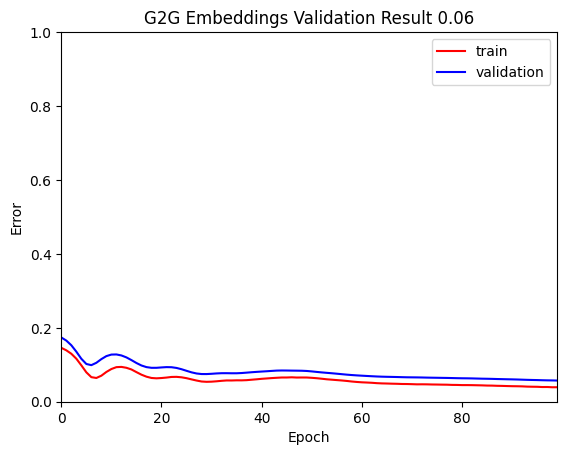

In [30]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_ylim(0,1); ax.set_xlim(0,EPOCHS-1)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('ogbn-arxiv Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()

### Qualitative Evaluations

In [31]:
import pandas as pd

Here we need to load in the separate file that maps MAG IDs to their title and abstracts. Later on, we will have to access another file that maps node indices to MAG IDs. With both taken together, we will be able to retrieve the original paper titles and abstracts of our predictions.

In [32]:
title_abs = pd.read_csv('./data/titleabs.tsv', sep='\t', header=None)
title_abs = title_abs.set_index(0)
title_abs.head()

,1,2
0,,
200971,ontology as a source for rule generation,This paper discloses the potential of OWL (Web...
549074,a novel methodology for thermal analysis a 3 d...,The semiconductor industry is reaching a fasci...
630234,spreadsheets on the move an evaluation of mobi...,The power of mobile devices has increased dram...
803423,multi view metric learning for multi view vide...,Traditional methods on video summarization are...
1102481,big data analytics in future internet of things,Current research on Internet of Things (IoT) m...


This is the mapping from node index to MAG ID, which comes in the directory created by `ogb`.

In [35]:
node2paper = pd.read_csv('./dataset/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz')
node2paper = node2paper.set_index('node idx')
node2paper

,paper id
node idx,
0,9657784
1,39886162
2,116214155
3,121432379
4,231147053
...,...
169338,3011696425
169339,3011708313
169340,3011798063


Let's look at paper 0 as our test paper. As before, we a tensor of all possible edges from this node, then have our model score their likelihoods, and then sort by the scores to find the model's predictions.

In [36]:
title_abs.loc[node2paper.loc[0]][1].item()

'evasion attacks against machine learning at test time'

In [37]:
qtarg = np.full(169342, 0)
#qother = np.hstack((np.arange(3), np.arange(4, 169343)))
qother = np.arange(1, 169343)
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[     0,      0,      0,  ...,      0,      0,      0],
        [     1,      2,      3,  ..., 169340, 169341, 169342]])

In [38]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [39]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted[:10]

array([ 67165, 115358, 166424, 154341, 106698, 133375, 141152,  93648,
       113094, 159655])

This paper only has 2 citations in the network.

In [43]:
graph_arx.edge_index[:, graph_arx.edge_index[0] == 0]

tensor([[    0,     0],
        [93487, 52893]])

In [48]:
for i in graph_arx.edge_index[:, graph_arx.edge_index[0] == 0][1].numpy():
  print(title_abs.loc[node2paper.loc[i]][1].item())

poisoning attacks against support vector machines
query strategies for evading convex inducing classifiers


Since paper 0 only had 2 citations, let's instead use paper 2, which has 7 citations, and could get us more informative predictions.

In [49]:
graph.edge_index[:, graph.edge_index[0] == 2]

tensor([[   2,    2,    2,    2,    2,    2,    2],
        [1098,    1, 2167, 1076, 2558, 2423, 1882]])

This paper seems to be about compressed sensing and MRI technology.

In [50]:
title_abs.loc[node2paper.loc[2]][1].item()

'on the absence of the rip in real world applications of compressed sensing and the rip in levels'

In [51]:
qtarg = np.full(169342, 2)
qother = np.hstack((np.arange(2), np.arange(3, 169343)))
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[     2,      2,      2,  ...,      2,      2,      2],
        [     0,      1,      3,  ..., 169340, 169341, 169342]])

In [52]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [53]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted

array([158459, 146547, 116653, ..., 154341, 115358, 106698])

In [54]:
qsorted[:10]

array([158459, 146547, 116653, 128457, 119217, 153676, 123812, 134265,
       107457, 103350])

Here are what the model recommends as prior readings. We have deep learning, distributed systems, cybersecurity, etc., but nothing on compressed sensing.

In [55]:
for i in qsorted[:10]:
  print(title_abs.loc[node2paper.loc[i]][1].item())

light field saliency detection with deep convolutional networks
ht paxos high throughput state machine replication protocol for large clustered data centers
graphical potential games
automated verification of role based access control policies constraints using prover9
learning a recurrent visual representation for image caption generation
cornerstones of sampling of operator theory
a correct precise and efficient integration of set sharing freeness and linearity for the analysis of finite and rational tree languages
predicting learning status in moocs using lstm
visuohaptic augmented feedback for enhancing motor skills acquisition
a model of plant identification system using glcm lacunarity and shen features


Here are papers that are actually cited by paper 2 (our test paper). As expected, there are multiple papers involving compressed sensing.

In [57]:
for i in graph_arx.edge_index[:, graph_arx.edge_index[0] == 2][1].numpy():
  print(title_abs.loc[node2paper.loc[i]][1].item())

stable and robust sampling strategies for compressive imaging
communications inspired projection design with application to compressive sensing
model based compressive sensing
on variable density compressive sampling
fundamental performance limits for ideal decoders in high dimensional linear inverse problems
sharp rip bound for sparse signal and low rank matrix recovery
on the theorem of uniform recovery of random sampling matrices
new bounds for restricted isometry constants
an analysis of block sampling strategies in compressed sensing


Let's look for the seminal paper, "Attention is all you need."

In [58]:
title_abs[1][title_abs[1].str.contains('attention is')]

0
2626778328                            attention is all you need
2946949951    attention is not all you need for commonsense ...
2948359136    attention is all you need for videos self atte...
2949170850    attention is all we need nailing down object c...
2951025380                         attention is not explanation
2968210605                     attention is not not explanation
2982652483    attention is all you need for chinese word seg...
2990220434    not all attention is needed gated attention ne...
3000577518    graph bert only attention is needed for learni...
3008579633    the perceptual boost of visual attention is ta...
Name: 1, dtype: object

In [59]:
node2paper['paper id'][node2paper['paper id'] == 2626778328]

node idx
41480    2626778328
Name: paper id, dtype: int64

In [62]:
graph_arx.edge_index[:, graph_arx.edge_index[1] == 41480].shape

torch.Size([2, 3382])

In [63]:
graph_arx.edge_index[:, graph_arx.edge_index[0] == 41480].shape

torch.Size([2, 23])

This paper is cited by `3382` other papers in this dataset, and cites `23` other papers in this dataset. Let's run inference on it.

In [64]:
qtarg = np.full(169342, 41480)
qother = np.hstack((np.arange(41480), np.arange(41481, 169343)))
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[ 41480,  41480,  41480,  ...,  41480,  41480,  41480],
        [     0,      1,      2,  ..., 169340, 169341, 169342]])

In [65]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [66]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted[:10]

array([131447, 143148,  88806, 158057, 162472,  94873, 145466,  56217,
       167569, 168344])

Here are the predictions. Sentiment analysis makes sense, along with some other deep learning topics, but nothing on attention or anything more fundamental.

In [67]:
for i in qsorted[:10]:
  print(title_abs.loc[node2paper.loc[i]][1].item())

sentiment analysis of financial news articles using performance indicators
deep multimodal embedding manipulating novel objects with point clouds language and trajectories
bounds on the second order coding rate of the mimo rayleigh block fading channel
multiagent soft q learning
data interpolating prediction alternative interpretation of mixup
pseudorandom generators for polynomial threshold functions
interpretable few shot learning via linear distillation
hierarchical subtask discovery with non negative matrix factorization
unmanaged internet protocol taming the edge network management crisis
towards service oriented 5g virtualizing the networks for everything as a service


### Modified Loss Function

Here we test out training our model using a modified loss function that penalizes the model for predicting links to papers that are too dissimilar in content to the test paper.

In [80]:
def train_with_combined_loss(model, train_data, val_data, optimizer, criterion, n_epochs=100):

  train_error = np.zeros(n_epochs)
  val_error = np.zeros(n_epochs)

  for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label, train_data.x, edge_label_index)
    loss.backward()
    optimizer.step()

    train_error[epoch-1] = loss.item()

    val_error[epoch-1] = evaluate_with_combined_loss(model, val_data, criterion)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Loss: {val_error[epoch-1]:.3f}")

  return model, train_error, val_error

@torch.no_grad()
def evaluate_with_combined_loss(model, data, criterion):
  model.eval()
  z = model.encode(data.x, data.edge_index)
  out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

  return criterion(out, data.edge_label, data.x, data.edge_label_index).item()


In [83]:
EPOCHS = 100

model = Net(graph_arx.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

bce = torch.nn.BCEWithLogitsLoss()
cosine_similarity = torch.nn.CosineSimilarity(dim=1)
def combined_loss_func(outputs, edge_label, x, edge_label_index):
  bce_loss = bce(outputs, edge_label)
  cosine_loss = -cosine_similarity(x[edge_label_index[0]], x[edge_label_index[1]]).mean()
  return .5 * bce_loss + .5 * cosine_loss


criterion = combined_loss_func
model, train_errs, val_errs  = train_with_combined_loss(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_auc = evaluate_with_combined_loss(model, test_data, criterion)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: -0.094, Val Loss: -0.042
Epoch: 020, Train Loss: -0.100, Val Loss: -0.045
Epoch: 030, Train Loss: -0.111, Val Loss: -0.048
Epoch: 040, Train Loss: -0.126, Val Loss: -0.053
Epoch: 050, Train Loss: -0.145, Val Loss: -0.058
Epoch: 060, Train Loss: -0.158, Val Loss: -0.063
Epoch: 070, Train Loss: -0.161, Val Loss: -0.065
Epoch: 080, Train Loss: -0.165, Val Loss: -0.065
Epoch: 090, Train Loss: -0.167, Val Loss: -0.066
Epoch: 100, Train Loss: -0.168, Val Loss: -0.066
Test: -0.067


We visualize the loss here as ROC-AUC doesn't make much sense here anymore since we aren't training purely based on the presence of a citation anymore.

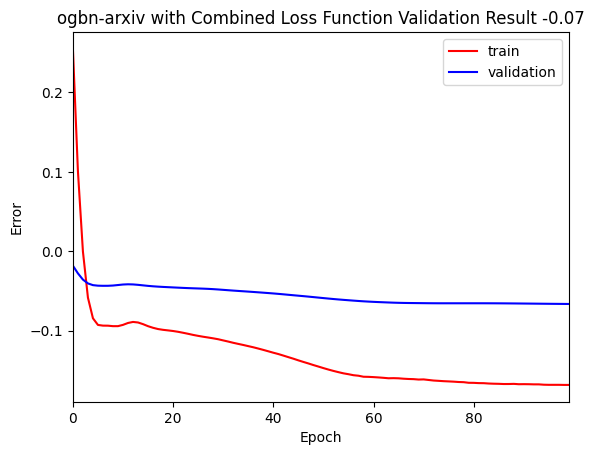

In [84]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_xlim(0,EPOCHS-1)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('ogbn-arxiv with Combined Loss Function Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()

In [85]:
qtarg = np.full(169342, 41480)
qother = np.hstack((np.arange(41480), np.arange(41481, 169343)))
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[ 41480,  41480,  41480,  ...,  41480,  41480,  41480],
        [     0,      1,      2,  ..., 169340, 169341, 169342]])

In [86]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [87]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted[:10]

array([ 88802,  99586,  77714, 135490, 119986, 125196,  43375, 119963,
        77682,  99825])

Here are the predictions from training with our balanced loss function. We actually have a paper here that uses the attention mechanism (3rd to last).

In [88]:
for i in qsorted[:10]:
  print(title_abs.loc[node2paper.loc[i]][1].item())

robust mimo harvest and jam helpers and relaying for secret communications
software defined networking based crypto ransomware detection using http traffic characteristics
limitations of algebraic approaches to graph isomorphism testing
deep speech denoising with vector space projections
analyzing the persistence of referenced web resources with memento
scaling binarized neural networks on reconfigurable logic
a cost speed reliability trade off to erasing
where and when to look deep siamese attention networks for video based person re identification
sar learning cross language api mappings with little knowledge
affinitynet semi supervised few shot learning for disease type prediction


**This time, we'll try training with a loss function that heavily penalizes dissimilar predictions.**

In [90]:
EPOCHS = 100

model = Net(graph_arx.num_features, 128, 64).to('cpu')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

bce = torch.nn.BCEWithLogitsLoss()
cosine_similarity = torch.nn.CosineSimilarity(dim=1)
def combined_loss_func(outputs, edge_label, x, edge_label_index):
  bce_loss = bce(outputs, edge_label)
  cosine_loss = -cosine_similarity(x[edge_label_index[0]], x[edge_label_index[1]]).mean()
  return .1 * bce_loss + .9 * cosine_loss


criterion = combined_loss_func
model, train_errs, val_errs  = train_with_combined_loss(model, train_data, val_data, optimizer, criterion, n_epochs=EPOCHS)

test_loss = evaluate_with_combined_loss(model, test_data, criterion)
print(f"Test: {test_loss:.3f}")

Epoch: 010, Train Loss: -0.659, Val Loss: -0.649
Epoch: 020, Train Loss: -0.662, Val Loss: -0.650
Epoch: 030, Train Loss: -0.665, Val Loss: -0.651
Epoch: 040, Train Loss: -0.669, Val Loss: -0.652
Epoch: 050, Train Loss: -0.671, Val Loss: -0.653
Epoch: 060, Train Loss: -0.672, Val Loss: -0.653
Epoch: 070, Train Loss: -0.673, Val Loss: -0.653
Epoch: 080, Train Loss: -0.674, Val Loss: -0.653
Epoch: 090, Train Loss: -0.674, Val Loss: -0.654
Epoch: 100, Train Loss: -0.674, Val Loss: -0.654
Test: -0.654


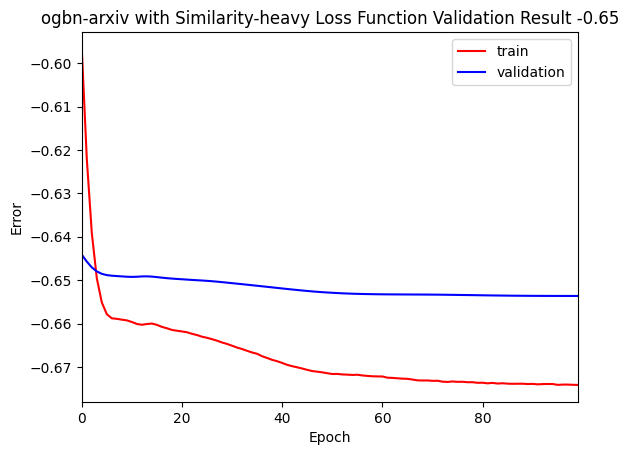

In [91]:
fig, ax = plt.subplots()
ax.plot(train_errs,'r-',label='train')
ax.plot(val_errs,'b-',label='validation')
ax.set_xlim(0,EPOCHS-1)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('ogbn-arxiv with Similarity-heavy Loss Function Validation Result %3.2f'%(val_errs[-1]))
ax.legend()
plt.show()

In [92]:
qtarg = np.full(169342, 41480)
qother = np.hstack((np.arange(41480), np.arange(41481, 169343)))
q_test_edge = np.vstack((qtarg, qother))
q_test_edge = torch.Tensor(q_test_edge).to(torch.int64)
q_test_edge

tensor([[ 41480,  41480,  41480,  ...,  41480,  41480,  41480],
        [     0,      1,      2,  ..., 169340, 169341, 169342]])

In [93]:
with torch.no_grad():
  model.eval()
  qz = model.encode(test_data.x, test_data.edge_index)
  qout = model.decode(qz, q_test_edge).view(-1).sigmoid()


In [94]:
qsorted = np.argsort(-qout.cpu().numpy())
qsorted[:10]

array([ 66649, 145260, 161123, 145247,  59346, 145169, 114873,  75912,
       161257, 103460])

Doesn't seem to provide any better predictions. If anything these might be worse than the predictions using the balanced loss function.

In [95]:
for i in qsorted[:10]:
  print(title_abs.loc[node2paper.loc[i]][1].item())

hmm based indic handwritten word recognition using zone segmentation
interpretable intuitive physics model
user taglines alternative presentations of expertise and interest in social media
a conceptual paper on servqual framework for assessing quality of internet of things iot services
non asymptotic output statistics of random binning and its applications
sparse stochastic inference for latent dirichlet allocation
simulating branching programs with edit distance and friends or a polylog shaved is a lower bound made
physical design obfuscation of hardware a comprehensive investigation of device and logic level techniques
texttt deepsqueeze decentralization meets error compensated compression
human centred object co segmentation
